# Random Survival Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
def model_data():
    train_df = pd.read_csv(r'C:\Users\grina\Desktop\VGTU\final_data.csv', index_col=0)
    train_df.reset_index(inplace=True)
    #replace empty values with 0
    train_df.fillna(value=0, inplace=True)
    train_df.drop(columns=['name', 'Parachute'], inplace=True)
    #change T, F with 1,0
    train_df['is_in_blue_zone'] = train_df['is_in_blue_zone'].replace({True:1, False:0})
    train_df['is_in_red_zone'] = train_df['is_in_red_zone'].replace({True:1, False:0})
    train_df['event'] = 1
    return train_df

In [36]:
%%time
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import train_test_split
from pysurvival.utils.display import display_loss_values
import torch
df_pysurvival_rsf = model_data()
df_pysurvival_rsf = pd.concat([df_pysurvival_rsf, pd.get_dummies(df_pysurvival_rsf['playing_type'], prefix='playing_type')], axis=1)
df_pysurvival_rsf.rename(columns={"playing_type_1":"solo", "playing_type_2":"duo", "playing_type_3":"squad"}, inplace=True)
#del multikolinearumo pasalinam duo playing_type_2 atributa
df_pysurvival_rsf.drop(columns=['duo'], inplace=True)
df_pysurvival_rsf.loc[(df_pysurvival_rsf['solo'] == 0) & (df_pysurvival_rsf['squad'] == 0), 'squad'] = 1
df_pysurvival_rsf['death_time'] = df_pysurvival_rsf['death_time'].div(60).round(0)

df_pysurvival_rsf.drop(columns=['distance_sum', 'index', 'playing_type', 'assist', 'item_stack_count', 'damage', 'dist_on_freefall', 'rank'], inplace=True)
index_train, index_test = train_test_split(range(df_pysurvival_rsf.shape[0]), test_size = 0.2, random_state=20)
data_train = df_pysurvival_rsf.loc[index_train].reset_index(drop = True)
data_test  = df_pysurvival_rsf.loc[index_test].reset_index(drop = True)
X_train, X_test = data_train.drop(columns=['death_time', 'event']), data_test.drop(columns=['death_time', 'event'])
T_train, T_test = data_train['death_time'].values, data_test['death_time'].values
E_train, E_test = data_train['event'].values, data_test['event'].values

rsf_model = RandomSurvivalForestModel(num_trees=150)
rsf_model.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=15, min_node_size=20)

Wall time: 52min 45s


RandomSurvivalForestModel

In [4]:
from pysurvival.utils.metrics import brier_score
def brier_score_plot(model, X, T, E, figure_size):
    
    times, brier_scores = brier_score(model, X, T, E)
    times.insert(0, 0)
    brier_scores.insert(0, 0)
    ibs_value = np.trapz(brier_scores, times)/max(T)

    fig, ax = plt.subplots(figsize=figure_size)
    title = 'Brier įvertinimų vidurkis = {:.2f}'
    title = title.format(ibs_value)
    ax.axhline(y=0.25, ls = 'dotted', color = 'red')
    ax.plot(times, brier_scores, color = 'blue', lw = 2)
    ax.set_xlim(0, max(T))
    ax.set_ylim(0)
    plt.xlabel('Laikas (min)', fontsize=13)
    plt.ylabel('Brier įvertinimas BS(t)', fontsize=13)
    ax.axhline(y=0.25, ls = 'dotted', color = 'red')
    plt.title(title, fontsize=18)
    plt.show()
    return ibs_value

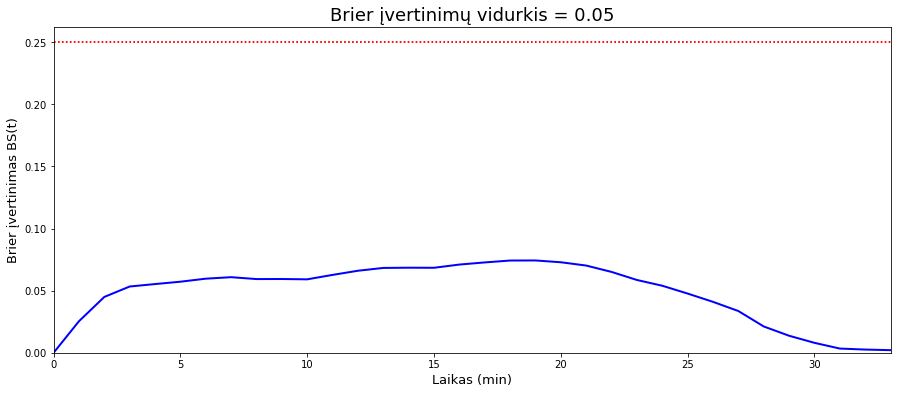

In [39]:
ibs = brier_score_plot(rsf_model, X_test, T_test, E_test, figure_size=(15, 6))

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error
from pysurvival import utils
from pysurvival.models.non_parametric import KaplanMeierModel
from pysurvival import utils
from pysurvival.utils import metrics

def act_to_est(model, X, T, E, figure_size, times = None,  metrics = ['rmse', 'mean', 'median']):
    kmf = KaplanMeierModel()
    kmf.fit(T, E)
    N = T.shape[0]
    if times is None:
        times = kmf.times
    actual = []
    predicted = []

    model_pred =  np.sum(model.predict_density(X), 0)
    for t in times:
        min_index = [abs(aj1-t) for (aj1, aj) in model.time_buckets]
        index = np.argmin(min_index)
        actual.append(N*kmf.predict_density(X,t))
        predicted.append(model_pred[index])
    #pradiniu momentu 0    
    #predicted[0] = 0   

    results = None
    title = 'Realus ir prognozuojamas ivykių skaičius'
    if metrics is not None:
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        med_ae = median_absolute_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)

        #jei ivertinimo reikia tik vieno
        if isinstance(metrics, str) :
            if 'rmse' in metrics.lower() or 'root' in metrics.lower():
                results = rmse
                title += "\n Šaknis iš vidutinės kvadratinės paklaidos = {:.3f}".format(rmse)
            elif 'median' in metrics.lower() :
                results = med_ae
                title += "\n Absoliutinės paklaidos mediana = {:.3f}".format(med_ae)
            elif 'mean' in metrics.lower() :
                results = mae
                title += "\n Vidutinė absoliutinė paklaida = {:.3f}".format(mae)
            else:
                raise NotImplementedError('{} nėra tokio įvertinimo'.format(metrics))

        #jei reikalingu ivertinimu reikia saraso
        elif isinstance(metrics, list):
            results = {}
            is_rmse = False
            if any( [ ('rmse' in m.lower() or 'root' in m.lower()) \
                for m in metrics ]):
                is_rmse = True
                results['rmse'] = rmse
                title += "\n Šaknis iš vidutinės kvadratinės paklaidos = {:.3f}".format(rmse)
            is_med_ae = False
            if any( ['median' in m.lower() for m in metrics ]):
                is_med_ae = True
                results['median'] = med_ae
                title += "\n Absoliutinių paklaidų mediana = {:.3f}".format(med_ae)
            is_mae = False
            if any( ['mean' in m.lower() for m in metrics ]):
                is_mae = True
                results['mean'] = mae
                title += "\n Vidutinė absoliutinė paklaida = {:.3f}".format(mae)
            if all([not is_mae, not is_rmse, not is_med_ae]):
                error = 'Nurodyti vertinimai nerasti'
                raise NotImplementedError(error)

    fig, ax = plt.subplots(figsize=figure_size)
    ax.plot(times, actual, color='red', label='Realus', alpha=0.8, lw = 3)
    ax.plot(times, predicted, color='blue', label='Prognozuojamas', alpha=0.8, lw = 3)
    plt.xlim(0, max(T))
    ax.set_ylim(0)
    plt.xlabel('Laikas (min)', fontsize=13)
    plt.ylabel('Įvykių skaičius', fontsize=13)
    plt.title(title, fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()

    return results

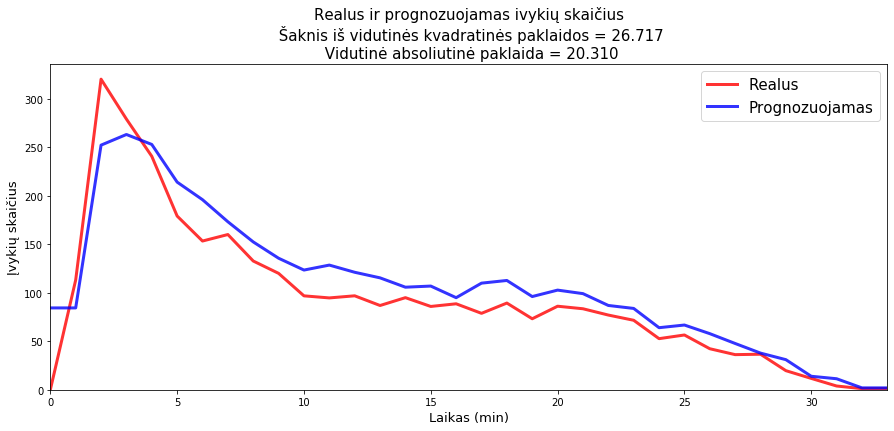

In [37]:
results_end = act_to_est(rsf_model, X_test, T_test, E_test, figure_size=(15, 6), metrics=['rmse', 'mean'])

In [38]:
c_index = concordance_index(rsf_model, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.91


In [20]:
rsf_model.variable_importance_table.head(5)

,feature,importance,pct_importance
0,dist_on_vehicle,25.195791,0.067702
1,heal_amount,18.227612,0.048978
2,dist_on_foot,17.561702,0.047189
3,First Aid Kit,11.383154,0.030587
4,Energy Drink,10.934793,0.029382


In [2]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
df_sksurv_rsf = model_data()
df_sksurv_rsf = pd.concat([df_sksurv_rsf, pd.get_dummies(df_sksurv_rsf['playing_type'], prefix='playing_type')], axis=1)
df_sksurv_rsf.rename(columns={"playing_type_1":"solo", "playing_type_2":"duo", "playing_type_3":"squad"}, inplace=True)
#del multikolinearumo pasalinam duo playing_type_2 atributa
df_sksurv_rsf.drop(columns=['duo'], inplace=True)
df_sksurv_rsf['death_time'] = df_sksurv_rsf['death_time'].div(60).round(0)
#df_sksurv_rsf['death_time'] = df_sksurv_rsf['death_time'].round(1)
random_state = 20
#df_sksurv_rsf.loc[(df_sksurv_rsf['solo'] == 0) & (df_sksurv_rsf['squad'] == 0), 'squad'] = 1
df_sksurv_rsf.drop(columns=['distance_sum', 'index', 'playing_type', 'assist', 'item_stack_count', 'damage', 'dist_on_freefall', 'rank'], inplace=True)
Xt = df_sksurv_rsf.drop(columns=['death_time', 'event'])

y = df_sksurv_rsf[['event', 'death_time']]
y.iloc[-1, y.columns.get_loc('event')] = 0
y['event'] = y['event'].astype('bool')
s = y.dtypes
yt = np.array([tuple(x) for x in y.values], dtype=list(zip(s.index, s)))

X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=random_state)
rsf = RandomSurvivalForest(n_estimators=30,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=30, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [8]:
import eli5
from eli5.sklearn import PermutationImportance
feature_names = Xt.columns.tolist()

perm = PermutationImportance(rsf, n_iter=4, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names, top=5)

In [10]:
train_min, train_max = y_train['death_time'].min(), y_train['death_time'].max()
test_min, test_max = y_test['death_time'].min(), y_test["death_time"].max()

0.9682614993841

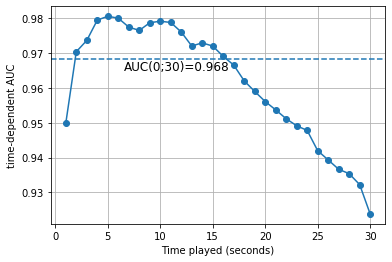

In [15]:
from sksurv.metrics import (concordance_index_censored,concordance_index_ipcw,cumulative_dynamic_auc)

times = np.arange(1, 31, 1)
va_auc, va_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf.predict(X_test), times)
plt.plot(times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("Time played (seconds)")
plt.ylabel("time-dependent AUC")
plt.grid(True)
va_mean_auc